# Penjelasan Kolom
1. Open:
* Harga saham pada saat pembukaan pasar pada hari perdagangan tertentu.
* Ini memberikan informasi tentang nilai saham sebelum perdagangan berlangsung.

2. High:
* Harga tertinggi yang dicapai oleh saham selama periode perdagangan (biasanya dalam satu hari).
* Ini menunjukkan potensi maksimum nilai saham selama waktu tertentu.

3. Low:
* Harga terendah yang dicapai oleh saham selama periode perdagangan.
* Memberikan wawasan tentang seberapa rendah harga saham dapat jatuh selama waktu tertentu.

3. Close:
* Harga saham pada akhir perdagangan pada hari tertentu.
* Ini adalah harga yang paling sering digunakan oleh trader dan analis untuk menganalisis performa saham.

4. Adj Close (Adjusted Close):
* Harga penutupan yang disesuaikan untuk dividen dan pemisahan saham (stock split).
* Ini memberikan gambaran yang lebih akurat tentang nilai saham dari waktu ke waktu, memperhitungkan peristiwa yang dapat memengaruhi harga saham.

5. Volume:
* Jumlah saham yang diperdagangkan selama periode perdagangan tertentu.
* Volume dapat memberikan informasi tentang likuiditas saham; volume tinggi biasanya menunjukkan minat yang kuat dari investor.

## Load Libraries

In [55]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import os
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import json
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

import warnings
warnings.filterwarnings("ignore")

## First Look at the Nvidia Dataset

In [56]:
folder_path = os.path.join(os.getcwd(),"..","data","raw")
folder_path = os.path.abspath(folder_path)
file_name = 'nvda_stock_prices.csv'
if os.path.exists(folder_path):
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path)


# df = yf.download('NVDA', start = '2021-10-31', end = '2024-10-31').reset_index()
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-10-07,4.614500,4.708500,4.605750,4.608250,4.585945,480984000
1,2019-10-08,4.516000,4.516000,4.412500,4.430750,4.409302,444436000
2,2019-10-09,4.508000,4.567500,4.479000,4.517750,4.495882,292412000
3,2019-10-10,4.515500,4.627000,4.510250,4.575750,4.553601,309124000
4,2019-10-11,4.660250,4.733500,4.641250,4.649750,4.627244,446404000
...,...,...,...,...,...,...,...
1253,2024-09-30,118.309998,121.500000,118.150002,121.440002,121.440002,226553700
1254,2024-10-01,121.769997,122.440002,115.790001,117.000000,117.000000,302094500
1255,2024-10-02,116.440002,119.379997,115.139999,118.849998,118.849998,221845900
1256,2024-10-03,120.919998,124.360001,120.339996,122.849998,122.849998,277118000


In [57]:
print(df.info())
print(f'Null Value: {df.isnull().sum().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Open       1258 non-null   float64
 2   High       1258 non-null   float64
 3   Low        1258 non-null   float64
 4   Close      1258 non-null   float64
 5   Adj Close  1258 non-null   float64
 6   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB
None
Null Value: 0


### Simple Preprocessing before Exploratory Data Analysis

In [58]:
# Simple Data Manipulation before EDA
df.columns = df.columns.str.lower().str.replace(' ','_')
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

## Exploratory Data Analysis (EDA)

### Visualize Close Price Trend

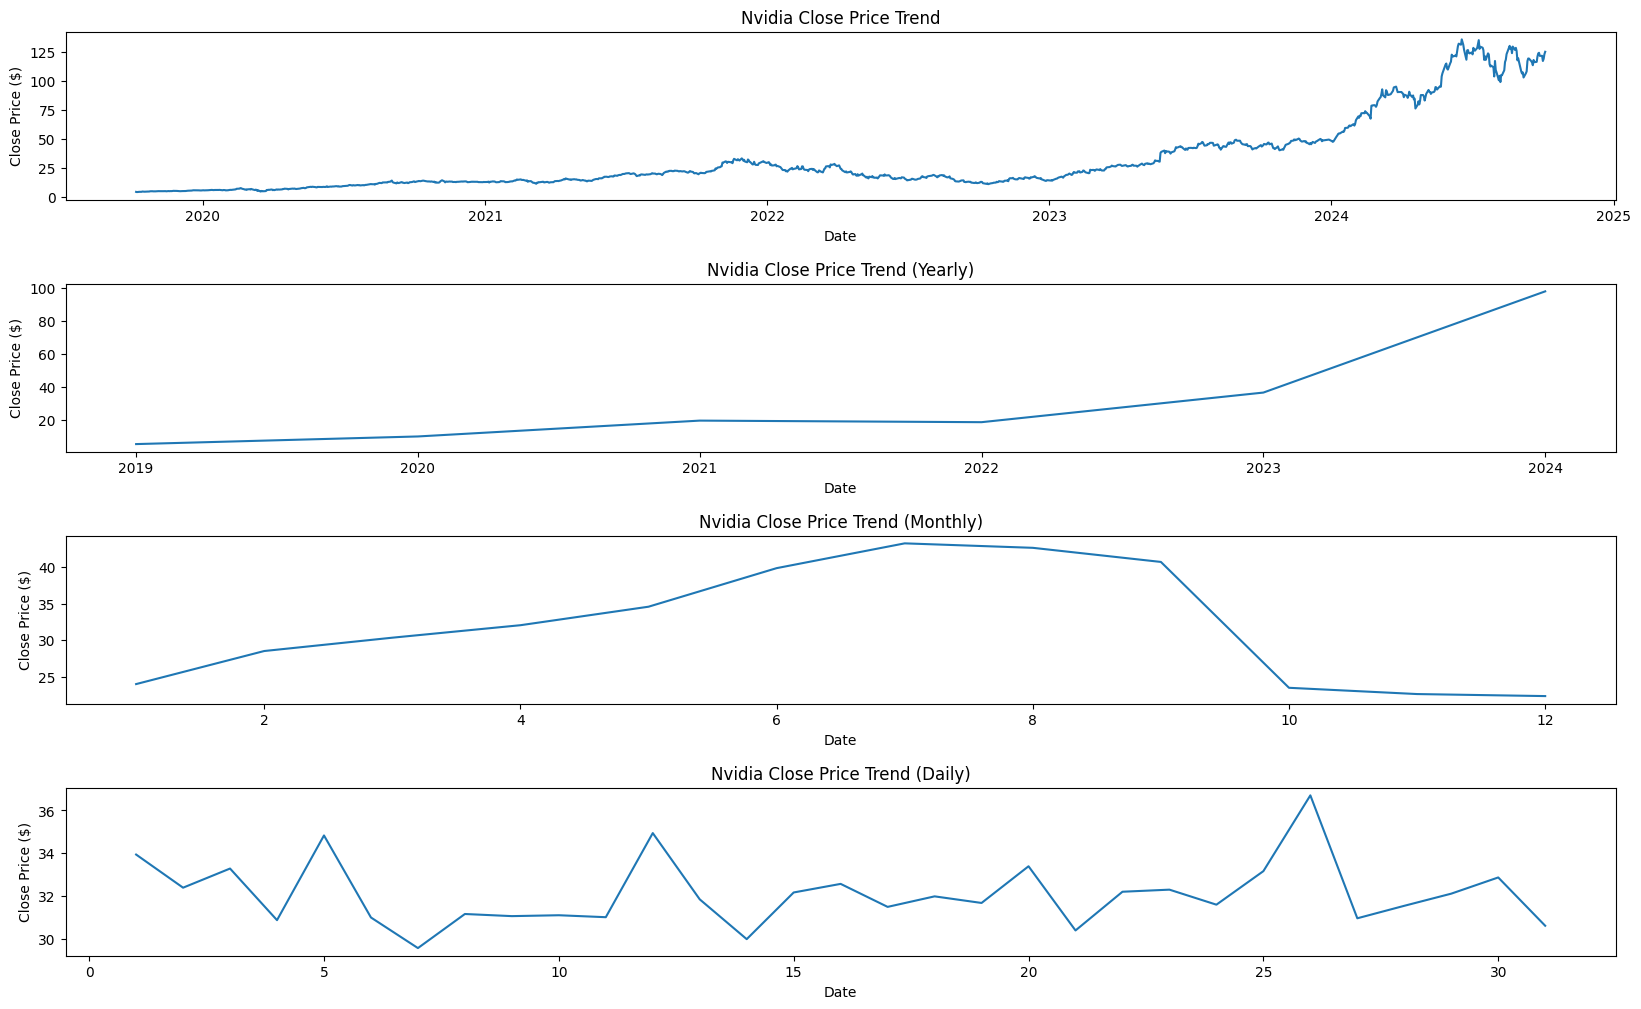

In [59]:
fig, ax = plt.subplots(4,1,figsize = (20,12))
fig.subplots_adjust(hspace = 0.5)
sns.lineplot(data = df, x= 'date', y = 'close', estimator = 'mean', ax = ax[0])
sns.lineplot(data = df, x = df['year'].astype(str), y = 'close', estimator = 'mean', errorbar = None, ax=ax[1])
sns.lineplot(data = df, x = df['month'].astype(int), y = 'close', estimator = 'mean', errorbar = None, ax=ax[2])
sns.lineplot(data = df, x = df['day'].astype(int), y = 'close', estimator = 'mean', errorbar = None, ax=ax[3])


ax[0].set_title('Nvidia Close Price Trend')
ax[1].set_title('Nvidia Close Price Trend (Yearly)')
ax[2].set_title('Nvidia Close Price Trend (Monthly)')
ax[3].set_title('Nvidia Close Price Trend (Daily)')
for i in range(len(ax)):
    ax[i].set_xlabel('Date')
    ax[i].set_ylabel('Close Price ($)')
plt.show()




Summaries:
* Long Term Trend: Based on first and second plot, Nvidia's stock has shown significant and steady growth from 2019 to 2024, with sharp increase in 2023 to 2024
* Medium Term Trend: Based on third plot, Nvidia's stock is growing until it drops around October to Desember
* Short Term Trend: Based on fourth plot, Nvidia's stock has fluctuates rapidly which indicate volatilite / unstablity

In [60]:
print(f'Nvidia Stock Row Number: {len(df)}')
print(f"number of rows where the values in 'Close' and 'Adj Close' are equal: {len(df['close'] == df['adj_close'])}")

Nvidia Stock Row Number: 1258
number of rows where the values in 'Close' and 'Adj Close' are equal: 1258


**Summary:**
* Histogram plots above show that all of the features are skewed

## Preprocessing

in this Project,I will only focus on Univariate Time Series Forecasting, where Close Price will be my main feaure to be predicted. So in the 1st preprocessing step, i will drop other features such as high, low, open, adj close and volume.

In [61]:
df.drop(columns = ['open', 'adj_close', 'volume', 'high','low'], axis = 1, inplace = True)

### Close Price Data Distribution (NVIDIA Stock)

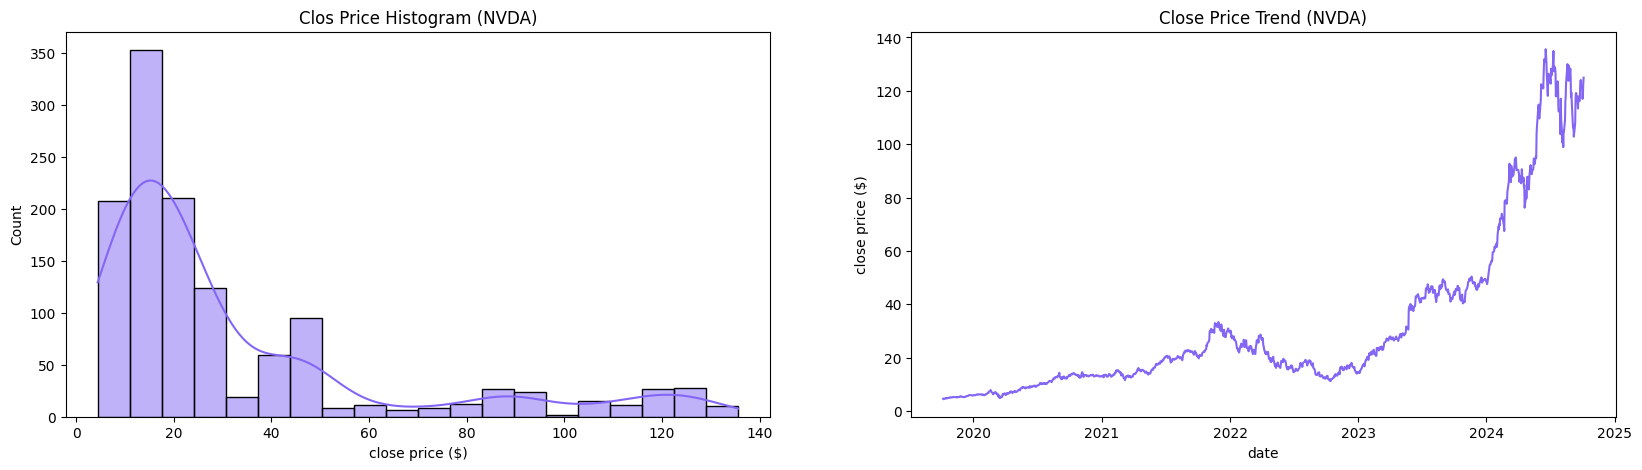

In [62]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.histplot(df, x = 'close', kde = True, color = '#8366f4', bins = 20)
plt.title('Clos Price Histogram (NVDA)')
plt.xlabel('close price ($)')
plt.subplot(1,2,2)
sns.lineplot(df, x = 'date', y = 'close', color = '#8366f4')
plt.title('Close Price Trend (NVDA)')
plt.ylabel('close price ($)')
plt.show()

* The histogram shows that most of NVIDIA’s closing stock prices are around $20. The line plot confirms this, showing that prices were mostly low until 2023. After 2023, the prices started to rise significantly.”
* This histogram also show us that close price data are skewed. Which will be handled in preprocessing step below

### Testing for Stationarity Using the Augmented Dickey-Fuller Test

In [63]:
# Generate the ADF test and get p-value

# features = ['close']
def adf_test(df):
    features = df.select_dtypes(include = 'float').columns.tolist()
    for i in features:
        p_value = adfuller(df[i])[1]
        if p_value > 0.05:
            print(f'p_value of {i} price data: {p_value}')
            print(f'The null Hypothesis (H0) failes to be rejected. The {i} price data is non stationary (has a trend or pattern)\n')
        else:
            print(f'p_value: {p_value}')
            print(f'The null Hypothesis (H0) rejected. The {i} price data is stationary (has no pattern)\n')
p_value = adf_test(df)

p_value of close price data: 0.9975276111259581
The null Hypothesis (H0) failes to be rejected. The close price data is non stationary (has a trend or pattern)



* Over the last five years, NVIDIA stock prices (Close and Adj Close) have shown a positive trend. After the COVID-19 pandemic (around 2022), the prices began to increase significantly.
* This comparison between Close and Adj Close indicates that there are no significant differences between the two prices, meaning it is acceptable to choose either the Close or Adj Close price.
* At a glance, this data exhibits a pattern (is non-stationary), but to confirm and reject this hypothesis, we will conduct the Augmented Dickey-Fuller Test, as referenced here: (https://www.statology.org/dickey-fuller-test-python/).
    * H0: The time series is non-stationary (has a pattern).
    * H1: The time series is stationary (has no pattern).
* If a p-value > 0.05: H0 fails ro be rejected
* If a p-value < 0.05: H0 rejected.

Summaries:
* Augmented Dickey-Fuller (ADF) test show result indicate that all features at this time range is non stationary. For some models data with inconsistent trends challenging to train effectively, leading to difficulties in producing accurate predictions.
* The next step is to convert the data into a stationary format by **differencing method**

Differencing can help stabilize the mean of the time series by removing changes in the level of a time series, and so reducing trend and seasonality


### Convert Close Price From Non Stationer to Stationer

#### Apply Transformation Log and Differencing Method

In [64]:
df['close_log'] = np.log(df['close'])
# df['close_log'],fitted_lambda = boxcox(df['close'])
df['close_log_diff'] = df['close_log'].diff()
df.dropna(inplace = True)
def plot_close_transformation(df = df, bins_number = 40, raw_color = 'indianred', log_color = '#32a3a3', log_diff_color = '#ffa631'):
    fig = make_subplots(
        cols=3, rows = 2, 
        subplot_titles= ['Trend (Original)', 'Trend (After Transformation Log)', 'Trend (After Transformation Log and Differencing)',
                        'Histogram (Original)', 'Histogram (After Transformation Log)', 'Histogram (After Transformation Log and Differencing)'])

    fig.add_trace(
        go.Scatter(
            x = df['date'], y = df['close'],
            line = dict(color = raw_color)), row = 1, col = 1)

    fig.add_trace(
        go.Scatter(
            x = df['date'], y = df['close_log'],
            line= dict(color = log_color)), row = 1, col = 2)

    fig.add_trace(
        go.Scatter(
            x = df['date'], y = df['close_log_diff'],
            line= dict(color = log_diff_color)), row = 1, col = 3)

    fig.add_trace(
        go.Histogram(
            x = df['close'],
            nbinsx = bins_number,
            marker_color=raw_color), row = 2, col = 1)
    fig.add_trace(
        go.Histogram(
            x = df['close_log'], 
            nbinsx = bins_number, 
            marker_color= log_color), row = 2, col = 2)
    
    fig.add_trace(
    go.Histogram(
        x = df['close_log_diff'], 
        nbinsx = bins_number, 
        marker_color= log_diff_color), row = 2, col = 3)

    fig.update_xaxes(title_text= 'Date', row=1, col=1)
    fig.update_xaxes(title_text= 'Date', row=1, col=2)
    fig.update_xaxes(title_text= 'Date', row=1, col=3)
    fig.update_yaxes(title_text= 'Close Price', row=1, col=1)
    fig.update_yaxes(title_text= 'Log Close Price', row=1, col=2)
    fig.update_yaxes(title_text = 'Count', row = 2, col = 1)
    fig.update_yaxes(title_text = 'Count', row = 2, col = 2)
    fig.update_yaxes(title_text = 'Count', row = 2, col = 3)

    fig.update_layout(title="NVIDIA Close Price Comparison: Original Scale vs Log Transformation vs Log Differencing", title_x = 0.5, template = 'simple_white', height = 800, width = 1700,showlegend = False)
    fig.show()
plot_close_transformation()

In [65]:
adf_test(df[['close_log_diff']])

p_value: 1.5845412026696676e-19
The null Hypothesis (H0) rejected. The close_log_diff price data is stationary (has no pattern)



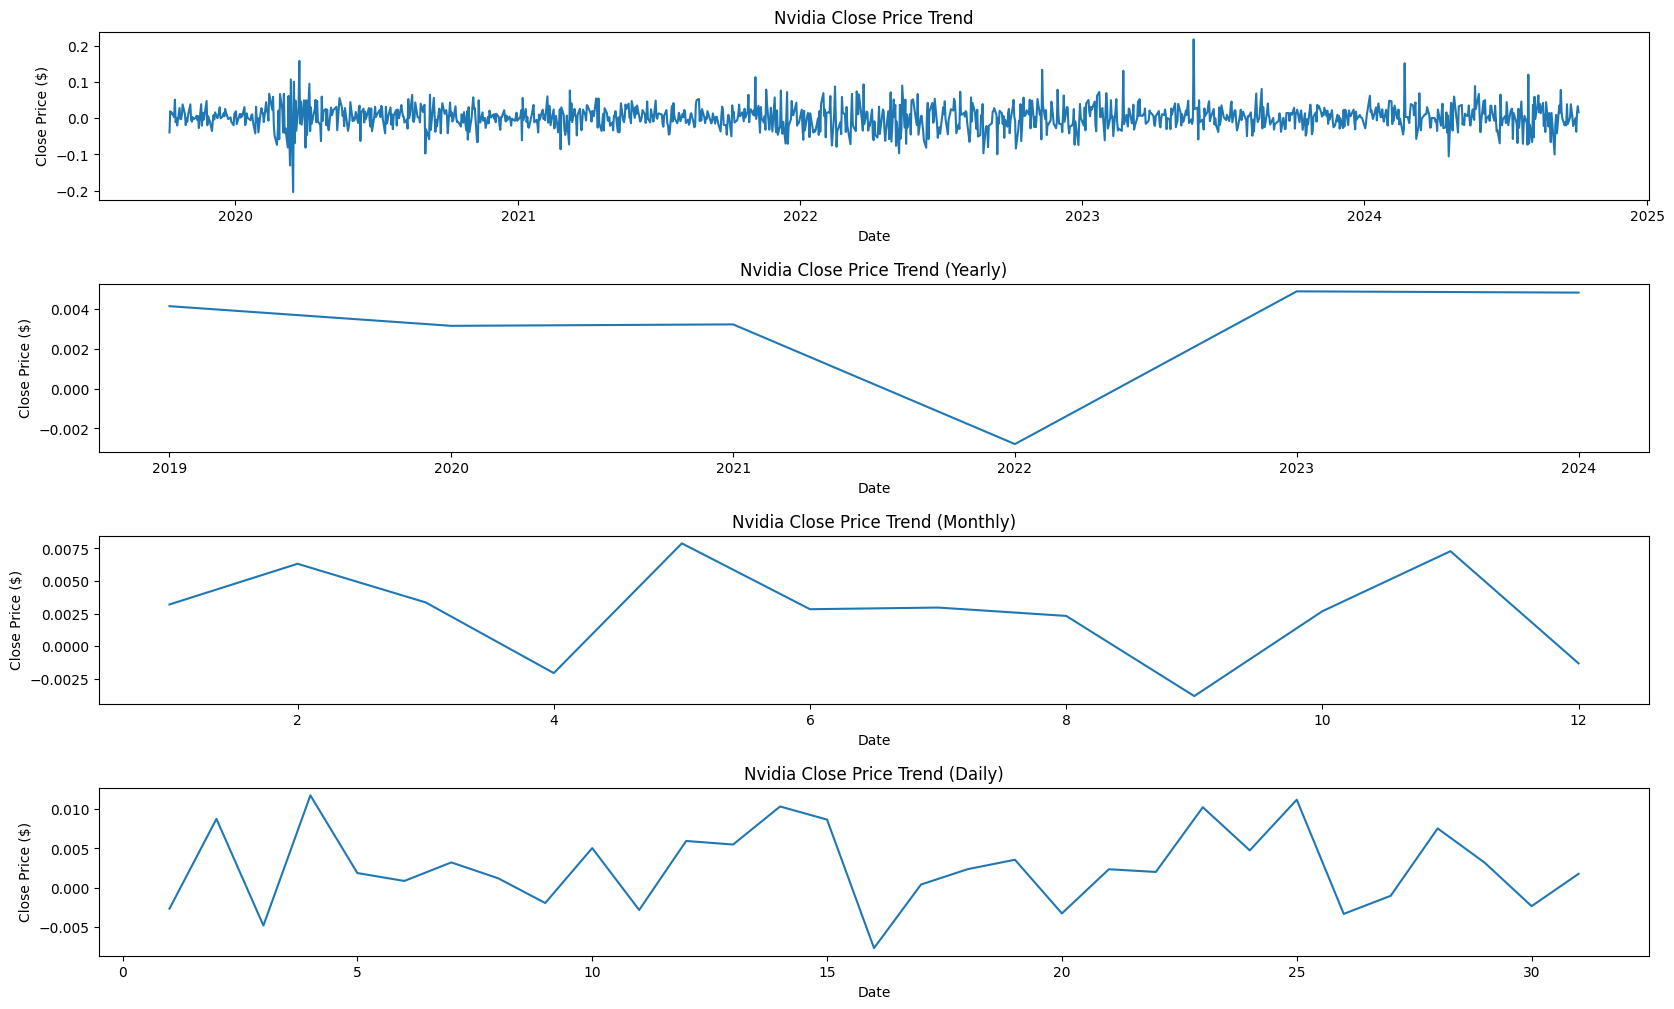

In [66]:
fig, ax = plt.subplots(4,1,figsize = (20,12))
fig.subplots_adjust(hspace = 0.5)
sns.lineplot(data = df, x= 'date', y = 'close_log_diff', estimator = 'mean', ax = ax[0])
sns.lineplot(data = df, x = df['year'].astype(str), y = 'close_log_diff', estimator = 'mean', errorbar = None, ax=ax[1])
sns.lineplot(data = df, x = df['month'].astype(int), y = 'close_log_diff', estimator = 'mean', errorbar = None, ax=ax[2])
sns.lineplot(data = df, x = df['day'].astype(int), y = 'close_log_diff', estimator = 'mean', errorbar = None, ax=ax[3])
ax[0].set_title('Nvidia Close Price Trend')
ax[1].set_title('Nvidia Close Price Trend (Yearly)')
ax[2].set_title('Nvidia Close Price Trend (Monthly)')
ax[3].set_title('Nvidia Close Price Trend (Daily)')
for i in range(len(ax)):
    ax[i].set_xlabel('Date')
    ax[i].set_ylabel('Close Price ($)')
plt.show()



#### ACF and PACF Visualization to define AR dan MA

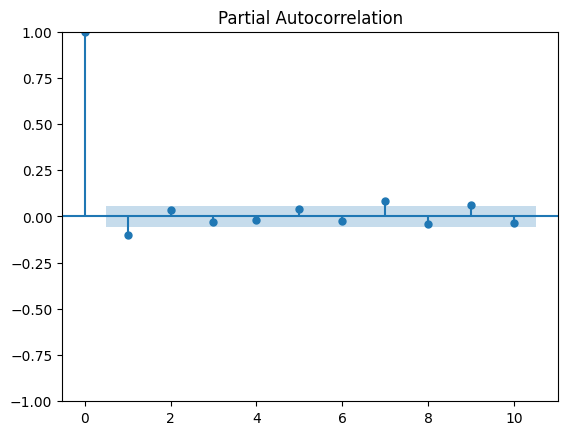

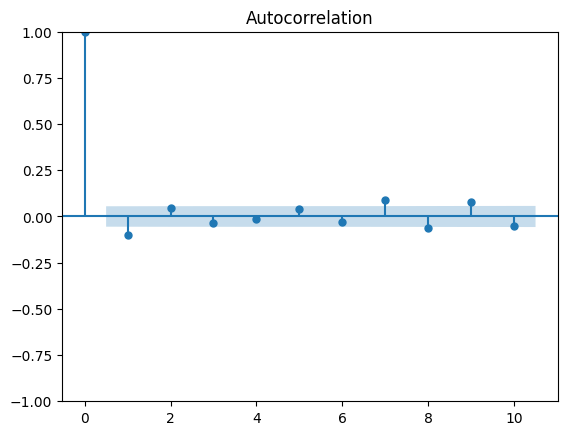

In [67]:
pacf_plot = plot_pacf(df['close_log_diff'], lags = 10)
acf_plot = plot_acf(df['close_log_diff'], lags = 10)

### Handle Missing Value

In [68]:
if df.isna().sum().sum() == 0:
    print('Nvidia Stock Data have no Missing Value')
else:
    # print(df.isna().sum())
    df.dropna(inplace= True)

Nvidia Stock Data have no Missing Value


### Feature Engineering

#### Lag Features

In [69]:
df['lag_1'] = df['close_log_diff'].shift(1)
df['lag_2'] = df['close_log_diff'].shift(2)
df['lag_3'] = df['close_log_diff'].shift(3)
df.dropna(inplace = True)

#### Rolling Windows

In [70]:
df['rolling_mean'] = df['close_log_diff'].rolling(window = 5).mean()
df.dropna(inplace = True)
df.set_index('date', inplace = True)

### Train Test Split

In [81]:
n_rows = int(len(df)*0.85)
df_train = df.iloc[:n_rows]
df_test = df.iloc[n_rows:]

features = df.drop(['close','close_log','close_log_diff'], axis = 1).columns.tolist()
exog_train = df_train[features]
exog_test = df_test[features]

In [82]:
df_test.head()

,close,year,month,day,close_log,close_log_diff,lag_1,lag_2,lag_3,rolling_mean
date,,,,,,,,,,
2024-01-08,52.252998,2024,1,8,3.956097,0.062299,0.022639,0.008978,-0.012514,0.010736
2024-01-09,53.139999,2024,1,9,3.972930,0.016833,0.062299,0.022639,0.008978,0.019647
2024-01-10,54.349998,2024,1,10,3.995445,0.022515,0.016833,0.062299,0.022639,0.026653
2024-01-11,54.821999,2024,1,11,4.004092,0.008647,0.022515,0.016833,0.062299,0.026586
2024-01-12,54.709999,2024,1,12,4.002046,-0.002045,0.008647,0.022515,0.016833,0.021650


In [83]:
print(df_train.shape, df_test.shape, exog_train.shape, exog_test.shape)

(1062, 10) (188, 10) (1062, 7) (188, 7)


## Modeling ARIMA

### Direct Train Test Split (80 % Train Size, 20 % Test Size)

In [74]:
#p (Autoregressive Order) = 1 (dari plot pacf)
#d (Differencing Order) = 0 (data sudah stationer), implement 1 jika data tidak stationer
#q (Moving Average Order) = 1 (dari plot acf)

model_arima = ARIMA(df_train['close_log_diff'], order=(1,0,1), exog = exog_train).fit() 
y_pred_arima = model_arima.get_forecast(steps = len(df_test), exog = exog_test).predicted_mean.values


df_pred_arima = pd.DataFrame({
    'close_pred': y_pred_arima}, index = df_test.index)


close_pred_original = np.exp(df_pred_arima['close_pred'].cumsum() + df_train['close_log'].iloc[-1])

df_pred_arima['close_pred_original']= close_pred_original


rmse_arima = root_mean_squared_error(df_test['close_log_diff'], df_pred_arima['close_pred'])
rmse_arima_original = root_mean_squared_error(df_test['close'], df_pred_arima['close_pred_original'])
print(f'RMSE Arima: {rmse_arima}')
print(f'RMSE Arima Original Scale: {rmse_arima_original}')

RMSE Arima: 0.022479422428990144
RMSE Arima Original Scale: 4.087089912201118


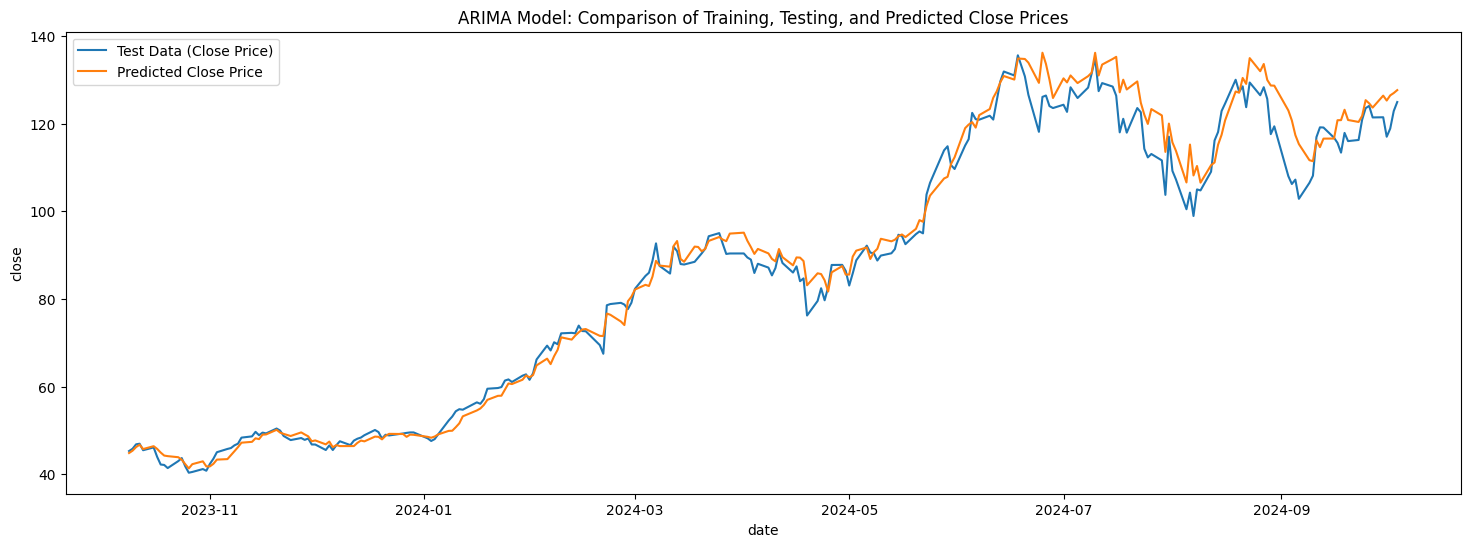

In [75]:
plt.figure(figsize = (18,6))
plt.title('ARIMA Model: Comparison of Training, Testing, and Predicted Close Prices')
# sns.lineplot(x = df_train.index, y = df_train['close'], label = 'Training Data (Close Price)')
sns.lineplot(x = df_test.index, y = df_test['close'], label = 'Test Data (Close Price)')
sns.lineplot(x = df_pred_arima.index, y = df_pred_arima['close_pred_original'], label = 'Predicted Close Price')
plt.show()

## Model Inference

In [76]:
import yfinance as yf
start_date = df_test.index.max() + relativedelta(days=1)
end_date = start_date + relativedelta(days=14)

df_inference = yf.download('NVDA', start = start_date,  end = end_date).reset_index()
df_inference.columns = df_inference.columns.str.lower()
df_inference.set_index('date', inplace= True)
df_inference

[*********************100%***********************]  1 of 1 completed


,open,high,low,close,adj close,volume
date,,,,,,
2024-10-07,124.989998,130.639999,124.949997,127.720001,127.720001,346250200
2024-10-08,130.259995,133.479996,129.419998,132.889999,132.889999,285722500
2024-10-09,134.110001,134.520004,131.380005,132.649994,132.649994,246191600
2024-10-10,131.910004,135.000000,131.000000,134.809998,134.809998,242311300
2024-10-11,134.009995,135.779999,133.660004,134.800003,134.800003,170209500
2024-10-14,136.470001,139.600006,136.300003,138.070007,138.070007,232347700
2024-10-15,137.869995,138.570007,128.740005,131.600006,131.600006,377831000
2024-10-16,133.979996,136.619995,131.580002,135.720001,135.720001,264879700
2024-10-17,139.339996,140.889999,136.869995,136.929993,136.929993,306435900


### Preprocessing Exog Varibles

### Predict and Show Comparison Plot

In [77]:
def save_model(model_arima):
    folder_name = os.path.abspath(os.path.join(os.getcwd(),"..","data","models"))
    model_name = 'arima_model.pkl'
    model_path = os.path.join(folder_name, model_name)
    # logging.info(f'Prepare to Save ARIMA Model to {model_path}')
    try:

        if os.path.exists(folder_name):
            model_arima.save(model_path)
            print('model saved')
            # logging.info(f"Saved ARIMA Model to {model_path}")
        else:
            # logging.error(CustomException(e,sys))
            print('error')
    except Exception as e:
        print(e)
        # logging.error(CustomException(e,sys))
        # raise CustomException(e,sys)

save_model(model_arima)

model saved


In [78]:
# import joblib
# import pickle
# model_path = os.path.abspath(os.path.join(os.getcwd(),'..','data','models', 'arima_model.pkl'))
# model_arima = joblib.load(model_path)
# # with open(model_path, 'rb') as f:
# #     model_arima = pickle.load(f)


6.106810890264298


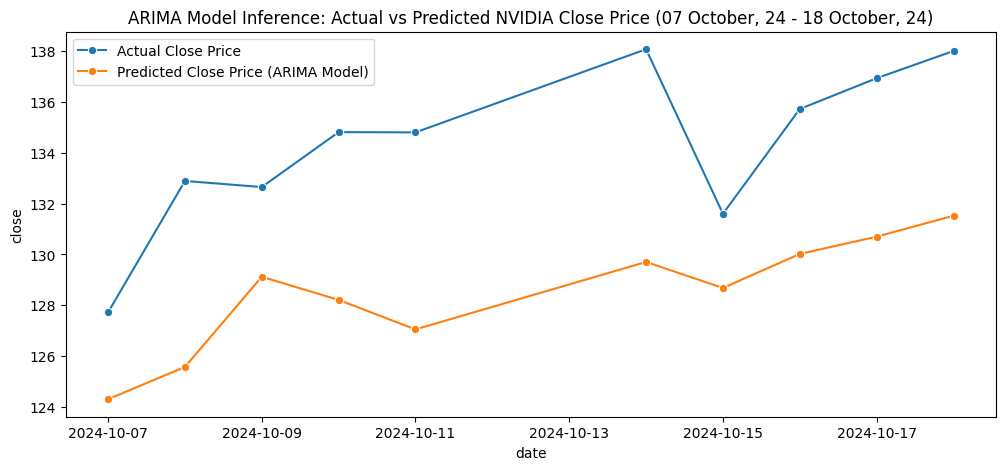

In [79]:
exog_future = df[features].tail(len(df_inference))
all_dates = pd.date_range(start=df_inference.index.min(), end = df_inference.index.max(),freq = 'B')
exog_future.index = all_dates
exog_future['year'] = all_dates.year
exog_future['month'] = all_dates.month
exog_future['day'] = all_dates.day



y_pred = model_arima.get_forecast(steps = len(df_inference), exog = exog_future).predicted_mean.values

df_future = pd.DataFrame({'close_pred':y_pred}, index = df_inference.index)
df_future['close_pred_original'] = np.exp(df_future['close_pred'].cumsum() + df['close_log'].iloc[-1])

min_date = df_inference.index.min().strftime('%d %B, %y')
max_date = df_inference.index.max().strftime('%d %B, %y')

plt.figure(figsize = (12,5))
plt.title(f'ARIMA Model Inference: Actual vs Predicted NVIDIA Close Price ({min_date} - {max_date})')
sns.lineplot(x = df_inference.index, y = df_inference['close'], label = 'Actual Close Price', marker = 'o')
sns.lineplot(x = df_future.index, y = df_future['close_pred_original'], label = 'Predicted Close Price (ARIMA Model)', marker = 'o' )
plt.legend()
# plt.show()

rmse_future = root_mean_squared_error(df_inference['close'], df_future ['close_pred_original'])                                                                                                                                
print(rmse_future)

## Save Model

In [80]:
# def save_model(model_arima):
#     folder_name = os.path.abspath(os.path.join(os.getcwd(),"..","src","config"))
#     model_name = 'arima_model.pkl'
#     model_path = os.path.join(folder_name, model_name)
#     # logging.info(f'Prepare to Save ARIMA Model to {model_path}')
#     try:

#         if os.path.exists(folder_name):
#             model_arima.save(model_path)
#             print('model saved')
#             # logging.info(f"Saved ARIMA Model to {model_path}")
#         else:
#             # logging.error(CustomException(e,sys))
#             print('error')
#     except Exception as e:
#         print(e)
#         # logging.error(CustomException(e,sys))
#         # raise CustomException(e,sys)

# save_model(model_arima)